## GAAIMS 
### EDSS prediction analysis on all 21 regress-N features for revision of paper: We do binary classification with groups Mild vs Moderate with EDSS 1-4.5 vs 5-6 respectively. 

In [69]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import warnings
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

In [9]:
path = 'C:\\Users\\purpl\\Box\\GAIT\\sample_data\\data_export\\'

In [31]:
#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\csv files\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L', 'index']
regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = regressN_df[regressN_df['Label']==1] #Keeping only PwMS

#Reading the EDSS scores for PwMS 
edss= pd.read_csv('..//edss.csv')
#Keeping edss of only the 17 PwMS subjects we have the raw data for 
edss = edss[edss['PID'].isin(regressN_df[regressN_df['Label']==1]['PID'].unique())].reset_index().drop('index', axis =1)

#Attaching the EDSS to the dataframe
regressN_df['edss'] = regressN_df['PID'].map(edss.set_index('PID')['EDSS'])

#Creating the new labels for mild (EDSS 1-4.5) vs moderate (EDSS 5-6)
regressN_df['Label'][regressN_df['edss']<=4.5] = 0 #0 for mild 
regressN_df['Label'][regressN_df['edss']>=5] = 1 #1 for moderate

#Shuffling 
regressN_df = shuffle(regressN_df, random_state = 0)
print('Regress-N data shape: ', regressN_df.shape)  #21 features + PID + Trial ID + Label = 24 features 

Regress-N data shape:  (3230, 25)
Regress-N data shape:  (1447, 25)


In [39]:
#No. of subjects in each category 
#mild has 9 subjects, moderate has 8 subjects
print ('No. of subjects in each category\n', \
       regressN_df[['PID', 'Label']].groupby('PID').first()['Label'].value_counts())

#No. of strides in each category 
#mild has 968 strides and moderate has 479 strides 
print ('No. of strides in each category \n', regressN_df['Label'].value_counts())

#No. of strides in each trial (for task generalization)
#Trial W has 749 strides and WT has 698 strides
print ('No. of strides in each trial (for task generalization)\n', regressN_df['TrialID'].value_counts())

#No. of strides in mild and moderate groups for trial W
#Mild has 488 strides, modearte has 261 strides 
print ('No. of strides in mild and moderate groups for trial W\n', \
       regressN_df[regressN_df['TrialID']==1]['Label'].value_counts())

#No. of strides in mild and moderate groups for trial WT
#Mild has 480 strides, moderate has 218 strides 
print ('No. of strides in mild and moderate groups for trial WT\n', \
       regressN_df[regressN_df['TrialID']==2]['Label'].value_counts())

No. of subjects in each category
 0    9
1    8
Name: Label, dtype: int64
No. of strides in each category 
 0    968
1    479
Name: Label, dtype: int64
No. of strides in each trial (for task generalization)
 1    749
2    698
Name: TrialID, dtype: int64
No. of strides in mild and moderate groups for trial W
 0    488
1    261
Name: Label, dtype: int64
No. of strides in mild and moderate groups for trial WT
 0    480
1    218
Name: Label, dtype: int64


## Task generalization 

In [49]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Input: dataframe, type of normalization (z-score or min-max)
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

In [50]:
def evaluate(model, test_features, trueY):
    test_labels = trueY['Label'] #Dropping the PID
    predictions = model.predict(test_features)
    try:
        prediction_prob = model.predict_proba(test_features)[:, 1] #Score of the class with greater label
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features)[:, 1] #For linear SVM 
    #Stride wise metrics 
    acc = accuracy_score(test_labels, predictions)
    p = precision_score(test_labels, predictions)
    r = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    auc = roc_auc_score(test_labels, prediction_prob)
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Correctly slassified strides i.e. 1 if stride is correctly classified and 0 if otherwise
    temp['correct'] = (temp['Label']==temp['pred'])

    #Proportion of correctly classified strides
    proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  
    proportion_strides_correct['True Label'] = regressN_testY.groupby('PID').first() 

    #Label for the person - 0=healthy, 1=MS patient
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
    (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
    (proportion_strides_correct['correct']<0.5) 

    #Probability of class 1 - MS patient for AUC calculation
    proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
    (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 
    
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_p = precision_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_r = recall_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_f1 = f1_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
    return proportion_strides_correct['prob_class1'], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc]

In [51]:
def models(trainX, trainY, testX, testY, model_name = 'random_forest'):
    '''
    training set: trainX, testX
    testing set: testX, testY
    model: model_name
    '''
    trainY1 = trainY['Label'] #Dropping the PID
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'n_estimators': [40,45,50],\
       'max_depth' : [15,20,25,None],\
       'class_weight': [None, 'balanced'],\
       'max_features': ['auto','sqrt','log2', None],\
       'min_samples_leaf':[1,2,0.1,0.05]
        }
        rf_grid = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator = rf_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv = 5)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = AdaBoostClassifier(random_state=0)
        grid = {
        'n_estimators':[50, 75, 100, 125, 150],\
        'learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0)
        grid = {
        'gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)

    if(model_name == 'gbm'): #GBM
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
        'learning_rate':[0.15,0.1,0.05], \
        'n_estimators':[50, 100, 150],\
        'max_depth':[2,4,7],\
        'min_samples_split':[2,4], \
        'min_samples_leaf':[1,3],\
        'max_features':[4, 5, 6]\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = xgboost.XGBClassifier(random_state=0)
        grid = {
            'min_child_weight': [1, 5],\
            'gamma': [0.1, 0.5, 1, 1.5, 2],\
            'subsample': [0.6, 0.8, 1.0],\
            'colsample_bytree': [0.6, 0.8, 1.0],\
            'max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'knn'): #KNN
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],\
            'p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = DecisionTreeClassifier(random_state=0)
        grid = {
            'min_samples_split': range(2, 50),\
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = LinearSVC(random_state=0)
        grid = {
            'loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        grid_search = LogisticRegression(random_state=0)
    
    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0)
        grid = {
            'hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    grid_search.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
#     print('best score: ', grid_search.best_score_)
#     print('best_params: ', grid_search.best_params_, grid_search.best_index_)
#     print('Mean cv accuracy on test set:', grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
#     print('Standard deviation on test set:' , grid_search.cv_results_['std_test_score'][grid_search.best_index_])
#     print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
#     print('Standard deviation on train set:', grid_search.cv_results_['std_train_score'][grid_search.best_index_])
#     print('Test set performance:\n')
    stride_person_metrics = evaluate(grid_search, testX, testY)
    return stride_person_metrics

In [52]:
regressN_df.head()

,stride_time,swing_time,stance_time,SS_R,DS_L,DS_R,stride_length,stride_width,cadence,stride_speed,...,force_TOL,force_MidSSL,LeftFPA,RightFPA,Butterfly_x_abs,ButterflySQ_x,PID,TrialID,Label,edss
1132,1.021009,1.060078,1.015518,1.210048,0.791148,0.798821,1.005695,1.302647,0.971529,0.945016,...,0.878790,1.006089,36.490480,-31.475932,2.271273,1.804914,304,1,0,4.0
1386,1.043847,0.955625,1.056445,0.838128,1.141059,1.442040,0.808661,4.057423,0.947809,0.779091,...,2.521334,3.514670,-21.335065,-3.428429,3.194682,1.027285,312,1,1,5.0
3071,0.999028,0.706307,1.135293,0.607797,1.616673,1.708293,0.477344,1.263956,0.992252,0.471694,...,0.981485,1.063091,11.813237,10.534152,1.587411,3.302921,313,2,1,6.0
2713,0.802052,0.897300,0.770817,0.945462,0.633881,0.608642,1.379308,1.452146,1.237765,1.674681,...,1.060654,0.818488,-25.976893,-1.218127,1.386055,1.741628,303,2,0,3.5
3222,0.887182,0.923771,0.844133,0.927179,0.797732,0.762221,1.155206,1.305673,1.115180,1.309499,...,1.021584,0.861227,5.382051,11.590910,1.144886,0.908248,323,2,0,3.0


In [53]:
#Trial W for training 
regressN_trial1 = regressN_df[regressN_df['TrialID']==1]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd
regressN_testX_norm = (regressN_testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(regressN_trainY))
print ('Mild strides in training set: ', len(regressN_trainY)-regressN_trainY['Label'].sum())
print('Moderate strides in training set: ', regressN_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(regressN_testY)) 
print ('Mild strides in test set: ', len(regressN_testY)-regressN_testY['Label'].sum())
print('Moderate strides in test set: ', regressN_testY['Label'].sum())
print ('Imbalance ratio (mild:moderate)= 1:', regressN_testY['Label'].sum()/(len(regressN_testY)-regressN_testY['Label'].sum()))

Strides in training set:  749
Mild strides in training set:  488
Moderate strides in training set:  261
Strides in test set:  698
Mild strides in test set:  480
Moderate strides in test set:  218
Imbalance ratio (mild:moderate)= 1: 0.45416666666666666


In [54]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
predicted_probs_person_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(regressN_trainX_norm, regressN_trainY, regressN_testX_norm, regressN_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person
    print ('********************************')

random_forest
Stride-based model performance:  0.9340974212034384 0.9387755102040817 0.8440366972477065 0.888888888888889 0.9848814984709482
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Person-based model performance:  0.9411764705882353 1.0 0.875 0.9333333333333333 1.0
********************************
adaboost
Stride-based model performance:  0.9355300859598854 0.9435897435897436 0.8440366972477065 0.8910411622276029 0.9807243883792048
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, le

In [55]:
#MLP on regress-N 
ml_models = ['mlp']

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(regressN_trainX_norm, regressN_trainY, regressN_testX_norm, regressN_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person.values
    print ('********************************')

    
regressN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
regressN_metrics.to_csv(path+'..//EDSSprediction//trial_generalize_regressN_21features.csv')
predicted_probs_person_regressN.to_csv(path+'..//EDSSprediction//trial_generalize_ROCresults_regressN_21features.csv')

mlp
Stride-based model performance:  0.9255014326647565 0.9322916666666666 0.8211009174311926 0.8731707317073171 0.976710626911315
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(42, 5, 21, 21, 21, 5, 120),
              learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=0,
              shuffle=False, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)
Person-based model performance:  1.0 1.0 1.0 1.0 1.0
********************************


In [56]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_accuracy,0.934097,0.935530,0.936963,0.929799,0.936963,0.928367,0.916905,0.944126,0.929799,0.925501
stride_precision,0.938776,0.943590,0.930693,0.937824,0.948454,0.966667,0.939560,0.949749,0.937824,0.932292
stride_recall,0.844037,0.844037,0.862385,0.830275,0.844037,0.798165,0.784404,0.866972,0.830275,0.821101
stride_F1,0.888889,0.891041,0.895238,0.880779,0.893204,0.874372,0.855000,0.906475,0.880779,0.873171
stride_AUC,0.984881,0.980724,0.966791,0.984461,0.981317,0.937758,0.894190,0.986535,0.983429,0.976711
person_accuracy,0.941176,1.000000,1.000000,1.000000,1.000000,0.941176,1.000000,1.000000,0.941176,1.000000
person_precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
person_recall,0.875000,1.000000,1.000000,1.000000,1.000000,0.875000,1.000000,1.000000,0.875000,1.000000
person_F1,0.933333,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,0.933333,1.000000
person_AUC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
regressN_metrics = pd.read_csv(path+'..//EDSSprediction//trial_generalize_regressN_21features.csv')
predicted_probs_person_regressN= pd.read_csv(path+'..//EDSSprediction//trial_generalize_ROCresults_regressN_21features.csv')

In [ ]:
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

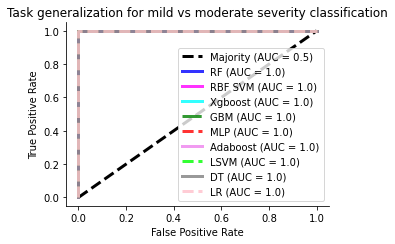

In [57]:
#ROC curve 
ml_models = ['random_forest',  'kernel_svm',  'xgboost', 'gbm', 'mlp', 'adaboost', 'linear_svm', 'decision_tree', 'logistic_regression'] 
#'knn', 
ml_model_names = {'random_forest': 'RF', 'adaboost': 'Adaboost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp': 'MLP'}
person_true_labels = regressN_testY.groupby('PID').first()
neutral = [0 for _ in range(len(person_true_labels))] # ROC for majority class prediction all the time 

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)
neutral_fpr, neutral_tpr, _ = roc_curve(person_true_labels, neutral) #roc curves

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

#RegressN Data 
axes.plot(neutral_fpr, neutral_tpr, linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    model_probs = predicted_probs_person_regressN[ml_model] # person-based prediction probabilities
    fpr, tpr, _ = roc_curve(person_true_labels, model_probs)
    axes.plot(fpr, tpr, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_AUC'][ml_model], 3))
                 +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('Task generalization for mild vs moderate severity classification')
plt.legend()
# axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//EDSSprediction//ROC_task_generalize_regressN_21features.png', dpi = 350)
plt.show()

## Subject generalization

In [148]:
def evaluate(model, test_features, yoriginal_, ypredicted_):
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 5
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []
    #For ROC curves 
    tpr_list = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold

        #Correctly classified strides i.e. 1 if stride is correctly classified and 0 if otherwise
        temp['correct'] = (temp['Label']==temp['pred'])

        #Proportion of correctly classified strides
        proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  

        proportion_strides_correct['True Label'] = temp[['PID', 'Label']].groupby('PID').first() 

        #Label for the person - 0=healthy, 1=MS patient
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
        (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
        (proportion_strides_correct['correct']<0.5) 

        #Probability of class 1 - MS patient for AUC calculation
        proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
        (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 

        fpr, tpr, _ = roc_curve(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tpr_list.append(tpr)

        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1']))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)

    return tpr_list, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [149]:
def acc(y_true,y_pred):
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [153]:
#We do not use LDA/QDA since our features are not normally distributed 
def models(X, Y, model_name = 'random_forest'):
    '''
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name
    '''
    Y_ = Y['Label'] #Dropping the PID
    groups_ = Y['PID']
    gkf = GroupKFold(n_splits=5) 
#     for train_index, test_index in gkf.split(X, Y_, groups=groups_):
#         print (Y.iloc[train_index], Y.iloc[test_index])
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15]#,0.1,0.05], \
        ,'gradientboostingclassifier__n_estimators':[50]#, 100, 150],\
        ,'gradientboostingclassifier__max_depth':[2]#,4,7],\
        ,'gradientboostingclassifier__min_samples_split':[2]#,4], \
        ,'gradientboostingclassifier__min_samples_leaf':[1]#,3],\
        ,'gradientboostingclassifier__max_features':['auto']#,'sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(StandardScaler(), xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(StandardScaler(), KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
        grid = {
            'linearsvc__loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(StandardScaler(), LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'mlp'):
        mlp_grid = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0))
        grid = {
        'mlpclassifier__hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                                    , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
    tpr_list, stride_person_metrics = evaluate(grid_search, Y, yoriginal, ypredicted)
    return tpr_list, stride_person_metrics

In [154]:
#CV for people generalize so no train-test split
X_regressN = regressN_df.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
Y_regressN = regressN_df[['PID', 'Label']] #PID to compute person based metrics later 

In [155]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression'] #
regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
tprs_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_regressN, Y_regressN, ml_model)
    regressN_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_regressN[ml_model] = tprs
    print ('********************************')

# regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
#                      'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
#                      'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
#                      'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
#                      'person_std_AUC']  
# regressN_metrics.to_csv(path+'..//EDSSprediction//subject_generalize_regressN_21features.csv')
# tprs_regressN.to_csv(path+'..//EDSSprediction//subject_generalize_ROCresults_regressN_21features.csv')

logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.9000940905282908, 0.8765620271096944, 0.7986709896238016, 0.8281448467420873, 0.960162255171]
Stride-based model performance (standard deviation):  [0.06172612543981298, 0.1177862807632813, 0.1693564367738381, 0.12158008423997459, 0.034055653002723965]
Person-based model performance (mean):  [0.95, 0.9, 1.0, 0.9333333333333333, 1.0]
Person-based model performance (standard deviation):  [0.09999999999999999, 0.2, 0.0, 0.13333333333333336, 0.0]
********************************


In [156]:
#MLP on regress-N 
ml_models = ['mlp']

for ml_model in ml_models:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_regressN, Y_regressN, ml_model)
    regressN_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_regressN[ml_model] = tprs
    print ('********************************')

regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv(path+'..//EDSSprediction//subject_generalize_regressN_21features.csv')
tprs_regressN.to_csv(path+'..//EDSSprediction//subject_generalize_ROCresults_regressN_21features.csv')

mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 10, 100, 30, 30, 30, 10)}
Stride-based model performance (mean):  [0.9113519891575479, 0.8399606567750281, 0.853589231836845, 0.8357067788757565, 0.9600248768539519]
Stride-based model performance (standard deviation):  [0.04231079360728828, 0.1154714925254503, 0.1555339452489808, 0.10195726186745421, 0.0478696967017956]
Person-based model performance (mean):  [1.0, 1.0, 1.0, 1.0, 1.0]
Person-based model performance (standard deviation):  [0.0, 0.0, 0.0, 0.0, 0.0]
********************************


In [157]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_mean_accuracy,0.903568,0.890679,0.929576,0.858441,0.921750,0.857875,0.854216,0.909757,0.900094,0.911352
stride_mean_precision,0.877612,0.842442,0.908205,0.865342,0.911125,0.867764,0.806762,0.882262,0.876562,0.839961
stride_mean_recall,0.848434,0.877443,0.859934,0.776462,0.844853,0.727152,0.753852,0.802899,0.798671,0.853589
stride_mean_F1,0.853236,0.843585,0.878144,0.786530,0.869576,0.769992,0.755994,0.833278,0.828145,0.835707
stride_mean_AUC,0.963422,0.959034,0.981956,0.952480,0.979145,0.906004,0.843086,0.958868,0.960162,0.960025
stride_std_accuracy,0.055474,0.078794,0.025395,0.124329,0.035399,0.085453,0.054646,0.052504,0.061726,0.042311
stride_std_precision,0.074130,0.082299,0.060874,0.084475,0.083209,0.095856,0.135333,0.110326,0.117786,0.115471
stride_std_recall,0.120443,0.163883,0.106873,0.223136,0.106591,0.175561,0.169808,0.178690,0.169356,0.155534
stride_std_F1,0.049481,0.071076,0.059098,0.131458,0.062345,0.087265,0.099298,0.129295,0.121580,0.101957
stride_std_AUC,0.030570,0.016583,0.013074,0.026138,0.014807,0.052892,0.064413,0.042129,0.034056,0.047870


In [ ]:
regressN_metrics = pd.read_csv(path+'..//EDSSprediction//subject_generalize_regressN_21features.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

In [165]:
tprs_regressN = pd.read_csv(path+'..//EDSSprediction//subject_generalize_ROCresults_regressN_21features.csv')
tprs_regressN.index = tprs_regressN['Unnamed: 0']
tprs_regressN.drop('Unnamed: 0', axis = 1, inplace = True)

In [166]:
ml_models1 = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']

for model in ml_models1:
    for idx in range(5):
#         print (model, idx)
        tprs_regressN[model][idx] = np.array(list(map(float, tprs_regressN[model][idx][1:-1].split())))


#Adding MLP to the column of tprs 
# tprs_regressN['mlp'] = [tprs_regressN_MLP.iloc[0].values, tprs_regressN_MLP.iloc[1].values, tprs_regressN_MLP.iloc[2].values, \
#                         tprs_regressN_MLP.iloc[3].values, tprs_regressN_MLP.iloc[4].values, tprs_regressN_MLP.iloc[5].values, \
#                         tprs_regressN_MLP.iloc[6].values]

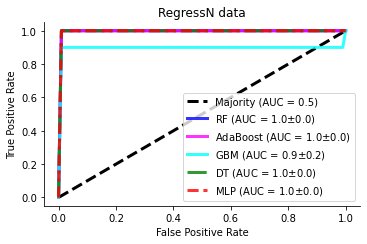

In [168]:
base_fpr = np.linspace(0, 1, 101)
ml_models = ['random_forest', 'adaboost', 'gbm', 'decision_tree', 'mlp'] #'knn'
ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

#RegressN Data 
axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    tprs = tprs_regressN[ml_model] # person-based prediction probabilities
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
#     axes[2].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    axes.plot(base_fpr, mean_tprs, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_mean_AUC']
                     [ml_model], 2)) + r'$\pm$' + str(round(regressN_metrics.loc['person_std_AUC']
                     [ml_model], 2)) + ')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('RegressN data')
axes.legend() #loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//EDSSprediction//ROC_subject_generalize_regressN_21features.png', dpi = 350)
plt.show()